## Analysing H1B Acceptance Trends 

H1B visa is a nonimmigrant visa issued to gradute level applicants allowing them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.\
**Motivation**: Our team consists of five international gradute students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa. 

### Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a>The Data provides insight into each petition with information such as the Job title, Wage, Employer, Worksite location etc. To get the dataset click on the above link-> click on Disclosure data -> scroll down to H1B data.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
# !pip install autocorrect
import pandas as pd
import numpy as np
import nltk,warnings
import clean_wage as cw
%matplotlib inline
import remove
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statistics import mean
nltk.download('words')
from autocorrect import Speller 
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder #ONE HOT ENCODING
from sklearn.ensemble import RandomForestClassifier #Build model - Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
nltk.download('wordnet')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bodav\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bodav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Exploratory Data Analysis

Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc. 

In [5]:
# file=pd.read_csv('/content/gdrive/My Drive/H-1B_Disclosure_Data_FY2019.csv')#Read the csv file and store it in file
file = pd.read_csv("C:\\Users\\bodav\\OneDrive\\H-1B_Disclosure_Data_FY2019.csv")

C:\Users\bodav\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,13,14,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,57,58,59,61,64,66,67,68,69,70,71,72,73,76,78,79,80,82,85,87,88,89,90,91,92,93,94,97,98,99,100,101,103,106,108,109,110,111,112,113,114,115,121,122,124,127,129,130,131,132,133,134,135,136,142,143,145,148,150,151,152,153,154,155,156,157,160,162,163,164,166,169,171,172,173,174,175,176,177,178,184,185,187,190,192,193,194,195,196,197,198,199,205,206,208,211,213,214,215,216,217,218,219,220,223,225,226,227,229,232,234,235,236,237,238,239,240,244,246,247,248,250,253,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cleaned=file[['CASE_NUMBER','CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','FULL_TIME_POSITION','JOB_TITLE','SOC_CODE','SOC_TITLE',\
              'EMPLOYER_NAME','WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1','NAICS_CODE','WORKSITE_CITY_1','WORKSITE_STATE_1']]
cleaned.shape

(1048547, 15)

In [7]:
print(cleaned['VISA_CLASS'].value_counts()) # similarly we can find the categories in CASE_STATUS and 'FULL_TIME_POSITION'
# Visa class has many categories which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)
#In case status we can drop withdrawn records and we can change certified-withdrawn to certified
cleaned.replace({"CASE_STATUS":"CERTIFIED-WITHDRAWN"},"CERTIFIED",inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
cleaned.info()

H-1B               649083
E-3 Australian      13087
H-1B1 Singapore      1291
H-1B1 Chile          1155
Name: VISA_CLASS, dtype: int64


C:\Users\bodav\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\bodav\Anaconda3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664615
Data columns (total 15 columns):
CASE_NUMBER                629856 non-null object
CASE_STATUS                629856 non-null object
CASE_SUBMITTED             629856 non-null object
DECISION_DATE              629856 non-null object
VISA_CLASS                 629856 non-null object
FULL_TIME_POSITION         629856 non-null object
JOB_TITLE                  629856 non-null object
SOC_CODE                   629852 non-null object
SOC_TITLE                  629852 non-null object
EMPLOYER_NAME              629848 non-null object
WAGE_RATE_OF_PAY_FROM_1    629852 non-null object
WAGE_UNIT_OF_PAY_1         629852 non-null object
NAICS_CODE                 629855 non-null float64
WORKSITE_CITY_1            629785 non-null object
WORKSITE_STATE_1           629845 non-null object
dtypes: float64(1), object(14)
memory usage: 76.9+ MB


In [8]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(type).value_counts()
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(cw.clean_wages).astype('float')
cleaned['WAGE_UNIT_OF_PAY_1'].value_counts()# the wage information that we have available has different unit of pay

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Year         587386
Hour          41927
Month           342
Bi-Weekly       105
Week             92
Name: WAGE_UNIT_OF_PAY_1, dtype: int64

In [9]:
# we convert the different units of pay to the type 'Year'
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Month',cleaned['WAGES'] * 12,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Hour',cleaned['WAGES'] * 2080,cleaned['WAGES']) # 2080=8 hours*5 days* 52 weeks
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Bi-Weekly',cleaned['WAGES'] *26,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Week',cleaned['WAGES'] * 52,cleaned['WAGES'])
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1'],axis=1,inplace=True)#we can drop the columns as cleaning is complete
cleaned.dropna(inplace=True)# We can check if we have null records using cleaned.info() and drop null records

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [10]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace(',', '')
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([cw.remove_num(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned['SOC_TITLE'].str.replace(',', '')

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [11]:
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())
spell = Speller()
def lemmatize_text(text):
     return lemmatizer.lemmatize(text)
def spelling_checker(text):
     return spell(text)

In [12]:
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [13]:
cleaned = cleaned.groupby("SOC_CODE").filter(lambda x: len(x) > 15)
cleaned = cleaned.groupby("SOC_TITLE").filter(lambda x: len(x) > 15)
cleaned['EMPLOYER_NAME'].value_counts()
cleaned = cleaned.groupby("EMPLOYER_NAME").filter(lambda x: len(x) > 15)
Top_Employer=cleaned['EMPLOYER_NAME'].value_counts()[:10]
cleaned['WAGE_CATEGORY'] = cleaned['WAGES'].apply(remove.wage_feature_eng)

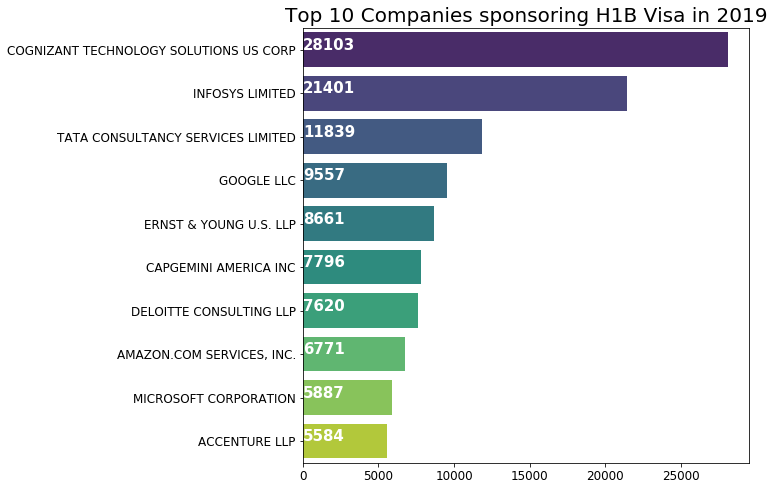

In [14]:
plt.figure(figsize=[8,8])
ax=sns.barplot(y=Top_Employer.index,x=Top_Employer.values,palette=sns.color_palette('viridis',10))
ax.tick_params(labelsize=12)
for i, v in enumerate(Top_Employer.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
plt.title('Top 10 Companies sponsoring H1B Visa in 2019', fontsize=20)
plt.show()

In [15]:
state={"AL":"ALABAMA","AK":"ALASKA","AZ":"ARIZONA","AR":"ARKANSAS","CA":"CALIFORNIA","CO":"COLORADO","DE":"DELAWARE",\
       "FL":"FLORIDA","GA":"GEORGIA","HI":"HAWAII","ID":"IDAHO","IL":"ILLINOIS","IN":"INDIANA","IA":"IOWA","KS":"KANSAS",\
       "KY":"KENTUCKY","LA":"LOUISIANA","ME":"MAINE","MD":"MARYLAND","MA":"MASSACHUSETTS","MI":"MICHIGAN","MN":"MINNESOTA",\
       "MS":"MISSISSIPPI","MO":"MISSOURI","MT":"MONTANA","NE":"NEBRASKA","NV":"NEVADA","NH":"NEW HAMPSHIRE","NJ":"NEW JERSEY",\
       "NM":"NEW MEXICO","NY":"NEW YORK","NC":"NORTH CAROLINA","ND":"NORTH DAKOTA","OH":"OHIO","OK":"OKLAHOMA","OR":"OREGON",\
       "PA":"PENNSYLVANIA","RI":"RHODE ISLAND","SC":"SOUTH CAROLINA","SD":"SOUTH DAKOTA","TN":"TENNESSEE","TX":"TEXAS",\
       "UT":"UTAH","VT":"VERMONT","VA":"VIRGINIA","WA":"WASHINGTON","WV":"WEST VIRGINIA","WI":"WISCONSIN","WY":"WYOMING",\
       "PR":"PUERTO RICO","VI":"U.S. VIRGIN ISLANDS","MP":"NORTHERN MARIANA ISLANDS","GU":"GUAM","MH":"MARSHALL ISLANDS",\
       "PW":"PALAU","DC":"DISTRICT OF COLUMBIA","CT":"CONNECTICUT"}
cleaned.replace({"WORKSITE_STATE_1": state})
cleaned = cleaned.groupby("WORKSITE_STATE_1").filter(lambda x: len(x) > 15) #removing less significant records

In [16]:
#CONVERTING CATEGORICAL COLUMNS INTO NUMERIC COLUMNS
cleaned.loc[(cleaned.CASE_STATUS == "CERTIFIED"),"CASE_STATUS"] = 1
cleaned.loc[(cleaned.CASE_STATUS == "DENIED"),"CASE_STATUS"] = 0
cleaned.loc[(cleaned.FULL_TIME_POSITION == "Y"),"FULL_TIME_POSITION"] = 1
cleaned.loc[(cleaned.FULL_TIME_POSITION == "N"),"FULL_TIME_POSITION"] = 0

### Baseline classifier

The baseline classifier is done with a basic model. In this case we are taking the mean of the labels ('certified' and 'denied' for H1B visa approvals). It will give us the base accuracy to which we will compare our classifier's accuracy. Our classifier should have a better accuracy than the baseline classifier accuracy.


In [ ]:
# This step assigns a binary class label (0 or 1) to each label for H1B visa approval. 
def create_class_labels(processed_data):
    y = np.where((processed_data['CASE_STATUS']=='CERTIFIED'),1, 0)
    return y
X = cleaned['CASE_STATUS'].to_numpy()
y = create_class_labels(cleaned)# Groundtruth labels for the dataset
counts = cleaned['CASE_STATUS'].value_counts()
print(counts)
print('proportion: ', counts[0]/counts[1], ': 1')

In [ ]:
class BaselineClasifier(): # Baseline classifier that predicts the class base on the mode of the labels.
    def __init__(self):
        self.central_tendency = None
    def fit(self, data, y, central_t='mode'): 
        label, counts = np.unique(y, return_counts=True) # Count labels and find the most frequent one 
        if central_t == 'mode':
            self.central_tendency = counts.argmax()
        elif central_t == 'mean':
            self.central_tendency = round(np.sum(y)/len(y))
        return self# Return an array with size equal to the data size  and each element setted to the mode.
    def predict(self, data):
        result = np.full(data.shape[0], self.central_tendency)
        return result

In [ ]:
def compute_accuracy(validation, predicted):
    comp = prediction == validation 
    match_counts = np.count_nonzero(comp == True) 
    clasifier_accuracy = match_counts/len(validation)
    return clasifier_accuracy  
def compute_AUC(y, prediction):
    auc = roc_auc_score(y, prediction)
    return auc

In [ ]:
accuracies = []
kf = sklearn.model_selection.KFold(n_splits=4, random_state=1, shuffle=True)# Testing with K-folds 
for train_idx, test_idx in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx] 
    baseline_clasifier = BaselineClasifier()
    classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
    prediction = baseline_clasifier.predict(X_test)
    fold_accuracy = compute_accuracy(y_test, prediction)
    fold_AUC = compute_AUC(y_test, prediction)
    accuracies.append(fold_accuracy)
baseline_clasifier_accuracy = mean(accuracies)
print('Baseline accuracy: ', baseline_clasifier_accuracy) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)# Testing with regular split
baseline_clasifier = BaselineClasifier()
classifier = baseline_clasifier.fit(X_train, y_train, 'mean')
prediction = baseline_clasifier.predict(X_test)
split_accuracy = compute_accuracy(y_test, prediction)
split_AUC = compute_AUC(y_test, prediction)
print('Baseline accuracy: ', split_accuracy)  

The accuracy results of the baseline classifier is 0.99. This result is due to the highly imbalanced data, where there are 624682 CERTIFIED applications and 5158 DENIED applications. The proportion of it is 121.10934470725087 to 1. Therefore, a performance measure based on the accuracy is not a good one. A better performance measure in imbalanced data is the Area under the ROC Curve (AUC). It meassures the likelihood that given two random points (one from the positive and one from the negative class) the classifier will rank the point from the positive class higher than the one from the negative one.

In [24]:
Dataset = cleaned[["CASE_STATUS", "FULL_TIME_POSITION","JOB_TITLE", "SOC_CODE", "SOC_TITLE", "EMPLOYER_NAME", "WORKSITE_STATE_1", "WAGE_CATEGORY"]]

In [27]:
def soc_code(x):
    if x in y:
        return x
    else:
        return 0
y = Dataset["SOC_CODE"].value_counts().head(70)
Dataset["TOP_SOC_CODE"] = Dataset["SOC_CODE"].apply(common_function)

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [28]:
def common_function(x):
    if x in y:
        return x
    else:
        return "others"
y = Dataset["JOB_TITLE"].value_counts().head(72)
Dataset["JOB_POSITION"] = Dataset["JOB_TITLE"].apply(common_function)
y = Dataset["SOC_TITLE"].value_counts().head(70)
Dataset["TOP_SOC_TITLE"] = Dataset["SOC_TITLE"].apply(common_function)
y = Dataset["EMPLOYER_NAME"].value_counts().head(70)
Dataset["TOP_EMPLOYER"] = Dataset["EMPLOYER_NAME"].apply(common_function)

C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\bodav\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [31]:
Dataset.drop(columns=['JOB_TITLE','SOC_CODE','SOC_TITLE','EMPLOYER_NAME',],axis=1,inplace=True)
Encoding = OneHotEncoder(handle_unknown='ignore',sparse = True)
Encoding_df = pd.DataFrame(Encoding.fit_transform(Dataset[["WORKSITE_STATE_1","JOB_POSITION","TOP_SOC_CODE","TOP_SOC_TITLE","TOP_EMPLOYER"]]).toarray())
Dataset = Dataset.join(Encoding_df)
Dataset.drop(columns=['WORKSITE_STATE_1','JOB_POSITION','TOP_SOC_CODE','TOP_SOC_TITLE','TOP_EMPLOYER','WAGE_CATEGORY'],axis=1,inplace=True)

In [33]:
Y = Dataset['CASE_STATUS'].values
X = Encoding_df
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=20)#Split the date into training and test set
model_clf = RandomForestClassifier(n_jobs=2,random_state=0)
model_clf.fit(X_train,y_train)#train the model
prediction_test = model_clf.predict(X_test)#test the model (predict with our test data)
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))#compare with original value, Y_test

C:\Users\bodav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy =  0.9950902755780805


### Reflection

What is the hardest part of the project that you’ve encountered so far?

1. Setting up the data for visualization and ML analysis, e.g. same job title is cluttered with different words, integers, and punctuation characters. 
2. Encoding the dataset to be used in the Classifier. We tried with JOB_TITLE attribute but got Memory error, instead, we started to use SOC_TITLE attribute